# General Qudit Deterministic Gates

In this notebook, we implement a recursive approach in order to implement gates on a circuit represented by a **unique qudit**. This photonic circuit requires only one photon and is therefore deterministic.

In [25]:
import perceval as pcvl
import perceval.lib.phys as phys
import numpy as np
import qiskit
from perceval.converters import QiskitConverter

In [2]:
def two(m):
    return int(2**m)

## Study of binary sequences

In order to implement our recursive approach, we need to be able to apply gates on subsets of qubits. For this purpose, identifying the appropriate entry modes is the most important step.

For the sake of simpicity, the gates will be numbred **from $1$ to $\text{n}$**.

We start by generating the list of all binary sequences of length $\text{n}$.

In [3]:
def binary_sequence(n):
    """
    Gives all the binary sequences of length n in a lexicographical order.
    """
    res = [bin(i)[2:] for i in range(two(n))]
    for i in range(len(res)):
        res[i]="0"*(n-len(res[i])) + res[i]
    return res

In [4]:
binary_sequence(2)

['00', '01', '10', '11']

In [5]:
binary_sequence(3)

['000', '001', '010', '011', '100', '101', '110', '111']

This is the most important function. It defines the mode permutation required for our recursive process.

In [6]:
def perm_list(n,j):
    """
    Helps to define the entry modes on a gate acting on (n-1)-qubits.
    
    Parameters:
        n: number of qubits
        j: qubit on which the gate does NOT act (1, ..., n)
    """
    N = two(n) # number of modes
    perm=[0 for i in range(N)]
    for k in range(int(two(j-1))):
        for i in range(two(n-j)):
            perm[k*two(n-j+1)+i]=k*two(n-j)+i
            perm[k*two(n-j+1)+i+two(n-j)]=k*two(n-j)+i+N//2
    return perm

In [7]:
perm_list(2,1)

[0, 1, 2, 3]

In [8]:
perm_list(2,2)

[0, 2, 1, 3]

In [9]:
perm_list(3,1)

[0, 1, 2, 3, 4, 5, 6, 7]

In [10]:
perm_list(3,2)

[0, 1, 4, 5, 2, 3, 6, 7]

In [11]:
perm_list(3,3)

[0, 4, 1, 5, 2, 6, 3, 7]

Now, we implement the inversion of any permutation defined by the permutation list.

In [12]:
def inv_perm(perm):
    res=[i for i in range(len(perm))]
    for i in range(len(perm)):
        res[perm[i]]=i
    return res

In [13]:
inv_perm([0, 1, 2, 3])

[0, 1, 2, 3]

In [14]:
inv_perm([0, 2, 1, 3])

[0, 2, 1, 3]

In [15]:
inv_perm([0, 4, 1, 5, 2, 6, 3, 7])

[0, 2, 4, 6, 1, 3, 5, 7]

In [104]:
circ=pcvl.Circuit(m=8)
circ.add((0,1,2,3,4,5,6,7), phys.PERM([0, 4, 1, 5, 2, 6, 3, 7]))
circ.add((0,1,2,3,4,5,6,7), phys.PERM([0, 2, 4, 6, 1, 3, 5, 7]))
pcvl.pdisplay(circ)

## Recursive circuits

In [17]:
def component(m, qubits, fun):
    """
    Function that defines the recursive representation over m modes of circuit defined at some size.
    
    Parameters:
        - m: the number of modes. m is supposed to be a power of 2.
    """
    n,M=len(qubits),int(np.log2(m))
    if n > M:
        raise(ValueError("There are two few modes for the needed qubits"))
    if n == M:  # the circuit is at the right size
        return fun()
    j_s=[True for i in range(M)]
    for q in qubits:
        j_s[q]=False
    for i in range(len(j_s)):
        if j_s[i]:
            j=i+1  # we add 1 because of the different conventions
            break
    for i in range(len(qubits)): # modify the numbers of the qubits
        if qubits[i] > j-1:
            qubits[i]-=1
    perm=perm_list(M,j)
    inv_p=inv_perm(perm)
    circ=pcvl.Circuit(m=m)
    circ.add([i for i in range(m)],phys.PERM(perm))
    temp=component(m//2, qubits, fun)
    circ.add(0, temp)
    circ.add(m//2, temp)
    circ.add([i for i in range(m)],phys.PERM(inv_p))
    return circ

In [26]:
qiskit_convertor = QiskitConverter(phys)

#### Example: the NOT gate on a qu-4-it

In [105]:
# on the first qubit
pcvl.pdisplay(component(4, [0], lambda:phys.PERM([1,0])))

In [106]:
# on the second qubit
pcvl.pdisplay(component(4, [1], lambda:phys.PERM([1,0])))

#### Example: Hadamard gate on a qu-4-it

In [107]:
# on the first qubit
pcvl.pdisplay(component(4, [0], lambda:phys.BS()))

In [108]:
# on the second qubit
pcvl.pdisplay(component(4, [1], lambda:phys.BS()))

#### Hadamard gate on a qu-8-it

In [109]:
# on the first qubit
pcvl.pdisplay(component(8, [0], lambda:phys.BS()))

In [110]:
# on the second qubit
pcvl.pdisplay(component(8, [1], lambda:phys.BS()))

In [111]:
# on the third qubit
pcvl.pdisplay(component(8, [2], lambda:phys.BS()))

#### The $\text{R}_{\text{x}}(\theta)$ gate

In [112]:
qc = qiskit.QuantumCircuit(1)
qc.rx(np.pi/3,0)
perceval_processor = qiskit_convertor.convert(qc)
pcvl.pdisplay(perceval_processor, recursive=True)

In [34]:
def r_x(m, qubits,theta):
    return component(m, qubits, lambda:phys.BS(theta=theta/2, phi_a=0,phi_b=np.pi, phi_d=0))

##### For a qubit

In [113]:
pcvl.pdisplay(r_x(2,[0],np.pi/12))

##### For a qu-4-it

In [114]:
# first qubit
pcvl.pdisplay(r_x(4,[0],np.pi/12))

In [115]:
# second qubit
pcvl.pdisplay(r_x(4,[1],np.pi/12))

##### For a qu-8-it

In [116]:
# first qubit
pcvl.pdisplay(r_x(8,[0],np.pi/12))

In [117]:
# second qubit
pcvl.pdisplay(r_x(8,[1],np.pi/12))

In [118]:
# third qubit
pcvl.pdisplay(r_x(8,[2],np.pi/12))

##### For a qu-16-it

In [119]:
# first qubit
pcvl.pdisplay(r_x(16,[0],np.pi/12))

In [120]:
# second qubit
pcvl.pdisplay(r_x(16,[1],np.pi/12))

In [121]:
# third qubit
pcvl.pdisplay(r_x(16,[2],np.pi/12))

In [122]:
# fourth qubit
pcvl.pdisplay(r_x(16,[3],np.pi/12))

#### The $\text{R}_{\text{y}}(\theta)$ gate

In [123]:
qc = qiskit.QuantumCircuit(1)
qc.ry(np.pi/3,0)
perceval_processor = qiskit_convertor.convert(qc)
pcvl.pdisplay(perceval_processor, recursive=True)

In [88]:
def r_y(m, qubits,theta):
    return component(m, qubits, lambda:phys.BS(theta=theta/2, phi_a=0,phi_b=np.pi/2, phi_d=0))

#### The CX gate (the smaller index controls the highest)

In [47]:
def CNOT():
    """
    Defines the CNOT gate on a qu-4it.
    """
    circ=phys.Circuit(4, name="CNOT")
    circ.add((0,1,2,3), phys.PERM([0,1,3,2]))
    return circ

In [124]:
pcvl.pdisplay(component(4, [0,1], CNOT))

In [125]:
pcvl.pdisplay(component(8, [0,1], CNOT))

In [126]:
pcvl.pdisplay(component(8, [0,2], CNOT))

In [127]:
pcvl.pdisplay(component(8, [1,2], CNOT))

In [128]:
pcvl.pdisplay(component(16, [0,1], CNOT))

In [129]:
pcvl.pdisplay(component(16, [0,2], CNOT))

In [130]:
pcvl.pdisplay(component(16, [0,3], CNOT))

In [131]:
pcvl.pdisplay(component(16, [1,2], CNOT))

In [132]:
pcvl.pdisplay(component(16, [1,3], CNOT))

In [133]:
pcvl.pdisplay(component(16, [2,3], CNOT))

#### The $\text{CP}(\theta)$ gate

In [63]:
def CP(phi):
    """
    Defines a CP(phi) gate on a qu-4-it.
    """
    circ=phys.Circuit(4, name="CP")
    circ.add(3, phys.PS(phi))
    return circ

In [134]:
pcvl.pdisplay(component(4, [0,1], lambda:CP(np.pi/3)))

In [135]:
pcvl.pdisplay(component(8, [0,1], lambda:CP(np.pi/3)))

In [136]:
pcvl.pdisplay(component(8, [0,2], lambda:CP(np.pi/3)))

In [137]:
pcvl.pdisplay(component(8, [1,2], lambda:CP(np.pi/3)))

In [138]:
pcvl.pdisplay(component(16, [0,1], lambda:CP(np.pi/3)))

In [139]:
pcvl.pdisplay(component(16, [0,2], lambda:CP(np.pi/3)))

In [140]:
pcvl.pdisplay(component(16, [0,3], lambda:CP(np.pi/3)))

In [141]:
pcvl.pdisplay(component(16, [1,2], lambda:CP(np.pi/3)))

In [142]:
pcvl.pdisplay(component(16, [1,3], lambda:CP(np.pi/3)))

In [143]:
pcvl.pdisplay(component(16, [2,3], lambda:CP(np.pi/3)))

#### The $\text{CCZ}$ gate

In [76]:
def CCZ():
    circ=pcvl.Circuit(m=8)
    circ.add(7, phys.PS(np.pi))
    return circ

In [144]:
pcvl.pdisplay(component(8, [0,1,2],CCZ))

In [145]:
pcvl.pdisplay(component(16, [0,1,2],CCZ))

In [146]:
pcvl.pdisplay(component(16, [0,1,3],CCZ))

In [147]:
pcvl.pdisplay(component(16, [0,2,3],CCZ))

In [148]:
pcvl.pdisplay(component(16, [1,2,3],CCZ))

In [149]:
pcvl.pdisplay(component(32, [0,1,2],CCZ))

#### The CCCZ gate

In [100]:
def CCCZ():
    circ=pcvl.Circuit(m=16)
    circ.add(15, phys.PS(np.pi))
    return circ

#### The CSWAP gate

In [85]:
def CSWAP():
    circ=pcvl.Circuit(m=8)
    circ.add((0,1,2,3,4,5,6,7),phys.PERM([0,1,2,3,4,6,5,7]))
    return circ

In [150]:
pcvl.pdisplay(component(8, [0,1,2],CSWAP))

### Implementation of the k-NN circuit

In this part, we refer the reader to the notebook named ```Library HQE - app to kNN```. In it, we learn that we can use swap test as a method in order to measure the distance between two data points.

For this purpose, we used the following circuit.

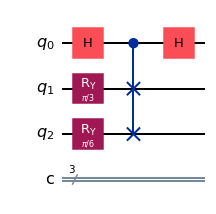

In [89]:
qc = qiskit.QuantumCircuit(3,3)
qc.h(0)
qc.ry(np.pi/3,1)
qc.ry(np.pi/6,2)
qc.cswap(0,1,2)
qc.h(0)
qc.draw("mpl", style="iqx")

In [92]:
phi_1=np.pi/3
phi_2=np.pi/6

In [151]:
circ=pcvl.Circuit(m=8)
circ.add(0, component(8, [0], lambda:phys.BS()))
circ.add(0,r_y(8, [1],phi_1))
circ.add(0,r_y(8, [2],phi_2))
circ.add(0,component(8, [0,1,2],CSWAP))
circ.add(0, component(8, [0], lambda:phys.BS()))
pcvl.pdisplay(circ,recursive=True)

Considering that the initial state is $000$, the circuit can be simplified into:

In [152]:
circ_opt=pcvl.Circuit(m=8)

# Hadamard gate
circ_opt.add((0,1,2,3,4,5,6,7), phys.PERM([0,4,2,3,1,5,6,7]))
circ_opt.add((0,1),phys.BS())
circ_opt.add((0,1,2,3,4,5,6,7), phys.PERM([0,4,2,3,1,5,6,7]))

# R_y(phi_1) gate
circ_opt.add((0,1,2,3,4,5,6,7), phys.PERM([0,2,1,3,4,6,5,7]))
circ_opt.add((0,1),phys.BS(theta=phi_1/2, phi_a=0,phi_b=np.pi/2, phi_d=0))
circ_opt.add((4,5),phys.BS(theta=phi_1/2, phi_a=0,phi_b=np.pi/2, phi_d=0))
circ_opt.add((0,1,2,3,4,5,6,7), phys.PERM([0,2,1,3,4,6,5,7]))

circ_opt.add(0,r_y(8, [2],phi_2))
circ_opt.add(0,component(8, [0,1,2],CSWAP))
circ_opt.add(0, component(8, [0], lambda:phys.BS()))
pcvl.pdisplay(circ_opt,recursive=True)

### Implementation of the $4-$qubit Grover algorithm

In [153]:
circ=pcvl.Circuit(m=16)

# Hadamard layer
circ.add(0, component(16, [0], lambda:phys.BS()))
circ.add(0, component(16, [1], lambda:phys.BS()))
circ.add(0, component(16, [2], lambda:phys.BS()))
circ.add(0, component(16, [3], lambda:phys.BS()))

# CCCZ
circ.add(0, CCCZ())

# Hadamard layer
circ.add(0, component(16, [0], lambda:phys.BS()))
circ.add(0, component(16, [1], lambda:phys.BS()))
circ.add(0, component(16, [2], lambda:phys.BS()))
circ.add(0, component(16, [3], lambda:phys.BS()))

# NOT layer 

circ.add(0, component(16, [0], lambda:phys.PERM([1,0])))
circ.add(0, component(16, [1], lambda:phys.PERM([1,0])))
circ.add(0, component(16, [2], lambda:phys.PERM([1,0])))
circ.add(0, component(16, [3], lambda:phys.PERM([1,0])))

# CCCZ
circ.add(0, CCCZ())

# NOT layer

circ.add(0, component(16, [0], lambda:phys.PERM([1,0])))
circ.add(0, component(16, [1], lambda:phys.PERM([1,0])))
circ.add(0, component(16, [2], lambda:phys.PERM([1,0])))
circ.add(0, component(16, [3], lambda:phys.PERM([1,0])))

# Hadamard layer

circ.add(0, component(16, [0], lambda:phys.BS()))
circ.add(0, component(16, [1], lambda:phys.BS()))
circ.add(0, component(16, [2], lambda:phys.BS()))
circ.add(0, component(16, [3], lambda:phys.BS()))

pcvl.pdisplay(circ, recursive=True)

### Tests

In this part, we test our gates.

#### CCX on $16$ modes

We suppose that a CCX gate is applied on the three first qubits of a four-qubit circuit.

In [155]:
def CCX():
    circ=pcvl.Circuit(m=8)
    circ.add((0,1,2,3,4,5,6,7),phys.PERM([0,1,2,3,4,5,7,6]))
    return circ

pcvl.pdisplay(CCX())

In [158]:
pcvl.pdisplay(component(16, [0,1,2], CCX))

In [159]:
circ=component(16, [0,1,2], CCX)
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0> 1.0
|0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1> 0.0


In [160]:
circ=component(16, [0,1,2], CCX)
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0> 1.0
|0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0> 0.0
|0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1> 0.0


### Remarks

1. We can define "reverse" multi-qubit gates (for eg. the second qubit is the control qubit and the first is the target), we only need to define the reverse elementary gate.
2. Our approach requires only $1$ photon, which avoids us the burden of making the photons indiscernable. It also has the advantage of not requiring ancilla modes.
3. Our method does not rely on post-selection. It is therefore a more natural one for photonic.
4. One drawback of our approach is that it requires an exponential number of modes (we multiply the number of modes by $2$ instead of adding $2$ modes). Approaches based purely on the knill CZ have a linear number of modes. This is important since the main limit on experimental implementation is the number of modes (at the time of writing $12$) and not the time.
5. A same gate is repeated $2^{m-N}$, where $m$ is the number of modes of the circuit and $N$ the number of modes defining the gate.
6. Our method is very unefficient for "sparse" gates, i.e. gates that contain a small number of components.
7. The simulation of these circuits is easier since we ony use one photon.